In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [5]:
def bgr2rgb(img):
    b,g,r = cv.split(img)
    return cv.merge([r,g,b])

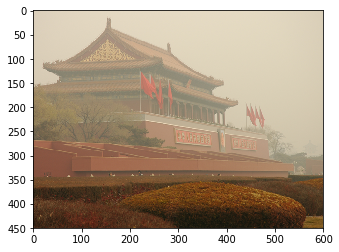

In [6]:
img = bgr2rgb(cv.imread("images/tiananmen1.png"))
plt.imshow(img);

## Obtaining the Dark Channel Prior
The dark channel prior is defined as: $$J^{dark}(x) = \min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(J^{c}(y)))$$

$\mathbf{J}$ is our image, $J^{c}$ is defined as a color channel of our image (one of red, blue, or green), and $\Omega(x)$ is a patch of pixels centered at $x$. 

Intuitively, $J^{dark}$ should be low in a haze-free region of the image.

In [37]:
def get_dark_channel_prior(img, omega=15):
    """
    img   -> 3D tensor in RGB format
    omega -> size of patch to consider (default is 15)
    """
    J_dark = np.ones(img.shape[:2])    
    padded = np.pad(img, ((omega//2,),(omega//2,),(0,)), 'edge')
    
    footprint = np.ones((omega,omega,3))
    
    J_dark = ndimage.minimum_filter(img,footprint=footprint,mode='nearest')
            
    return J_dark[:,:,1]

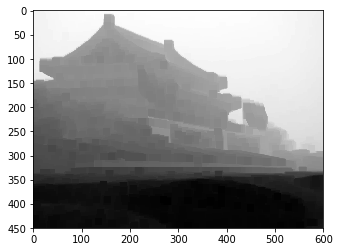

In [38]:
plt.imshow(get_dark_channel_prior(img, omega=15), cmap='gray');